In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from aero_design_functions import get_design_functions_1MW, single_point_design
from scipy.optimize import fsolve
from lacbox.io import load_pwr, load_ind, load_inds, load_ae, load_pc
from lacbox.test import test_data_path
from myteampack import MyHTC

def thickness(r, chord_root):
    """Absolute thickness [m] as a function of blade span [m] for 35-m blade"""
    p_edge = [
        9.35996e-8,
        -1.2911e-5,
        7.15038e-4,
        -2.03735e-2,
        3.17726e-1,
        -2.65357,
        10.2616,
    ]  # polynomial coefficients
    t_poly = np.polyval(p_edge, r)  # evaluate polynomial
    t = np.minimum(t_poly, chord_root)  # clip at max thickness
    return t

In [71]:


#Former class IA
V_rated_X = 11.4 # m/s
I_rated_X = 0.16

R_X = 89.17 # m

#New Class IIIB
I_rated_Y = 0.14



#V_rated_Y = (R_X/R_Y)**(2/3)*V_rated_X

#R_Y = ((V_rated_X*(1+2*I_rated_X))/(V_rated_Y*(1+2*I_rated_Y)))**(2/3)*R_X



In [72]:
"""Step 2"""

# Given values
#Former class IA
V_rated_X = 11.4  # m/s
I_rated_X = 0.16
R_X = 89.17  # m

#New Class IIIB
I_rated_Y = 0.14

# Define the system of nonlinear equations
def equations(vars):
    V_rated_Y, R_Y = vars
    eq1 = V_rated_Y - (R_X / R_Y)**(2/3) * V_rated_X
    eq2 = R_Y - ((V_rated_X * (1 + 2 * I_rated_X)) / (V_rated_Y * (1 + 2 * I_rated_Y)))**(2/3) * R_X
    return [eq1, eq2]

# Initial guesses for V_rated_Y and R_Y
initial_guess = [1, 1]

# Solve the system of equations
solution = fsolve(equations, initial_guess)

# Extract the solution
V_rated_Y, R_Y = solution

# Output the results
print(f"R_Y: {R_Y} m")
print(f"V_rated_Y: {V_rated_Y} m/s")

R_Y: 92.52423873190985 m
V_rated_Y: 11.122788574520852 m/s


{'curve': array([ 0.   ,  2.   ,  4.712,  5.396,  6.319,  7.475,  8.858, 10.458,
       12.268, 14.275, 16.467, 18.833, 21.356, 24.023, 26.817, 29.721,
       32.719, 35.791, 38.92 , 42.086, 45.272, 48.457, 51.623, 54.75 ,
       57.82 , 60.815, 63.716, 66.506, 69.168, 71.687, 74.047, 76.234,
       78.234, 80.037, 81.631, 83.006, 84.155, 85.07 , 85.746, 86.366]), 'chord': array([5.38   , 5.38   , 5.38   , 5.38   , 5.3886 , 5.4212 , 5.4865 ,
       5.5887 , 5.7247 , 5.8817 , 6.0346 , 6.1478 , 6.202  , 6.195  ,
       6.1292 , 6.0096 , 5.8432 , 5.64   , 5.4107 , 5.1613 , 4.8974 ,
       4.6255 , 4.3519 , 4.0827 , 3.822  , 3.5724 , 3.3364 , 3.1161 ,
       2.913  , 2.7275 , 2.5595 , 2.4087 , 2.266  , 2.1175 , 1.9588 ,
       1.7913 , 1.6013 , 1.3858 , 1.1384 , 0.83354]), 'rel_th': array([100.   , 100.   ,  96.915,  95.291,  92.664,  88.775,  83.448,
        76.689,  68.754,  60.273,  52.291,  45.826,  40.95 ,  37.343,
        34.518,  32.27 ,  30.488,  29.02 ,  27.756,  26.693,  25.829,


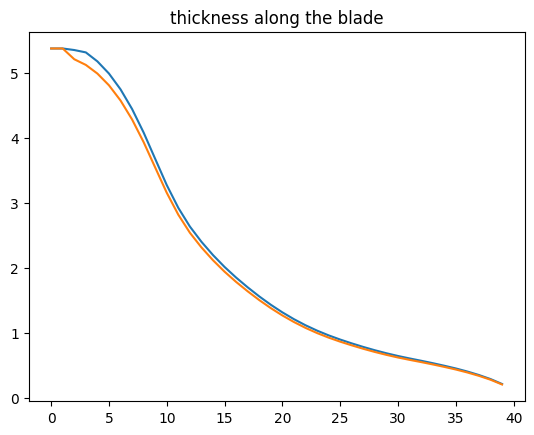

In [73]:
"""Step4"""

Data_ae = load_ae("DTU_10MW_RWT_ae.dat")

#Curve length   Blade chord     Relative thickness
#print(Data_ae)
data_ae = {
    'curve':Data_ae[:,0],
    'chord':Data_ae[:,1],
    'rel_th':Data_ae[:,2]

    }

print(data_ae)

t=data_ae["chord"]*data_ae["rel_th"]/100*R_Y/R_X
abs_t=data_ae["chord"]*data_ae["rel_th"]/100

#to force the thickness at the root and make it smoother
t[0:2]=data_ae["chord"][0:2]
t[2]=0.99*t[2]

#plot the former blade shape and the new one
plt.plot(t)
plt.plot(abs_t)
plt.title("thickness along the blade")
plt.show()

In [74]:
#Values to make a new htc file

htc = [[1, 0.00000E+00, 7.00600E-05, 4.44089E-16, -1.45000E+01],
[2, -2.06477E-05, -1.22119E-02, 3.00000E+00, -1.45000E+01], 
[3, -7.28810E-03, -2.49251E-02, 6.00000E+00, -1.44851E+01],
[4, -1.89235E-02, -2.73351E-02, 7.00004E+00, -1.44610E+01], 
[5,-5.41282E-02,-2.82163E-02,8.70051E+00,-1.43388E+01], 
[6, -1.26633E-01, -2.13210E-02, 1.04020E+01, -1.40201E+01], 
[7, -2.25666E-01, -1.28378E-02, 1.22046E+01, -1.33904E+01], 
[8, -2.88563E-01, -7.70659E-03, 1.32065E+01, -1.29371E+01], 
[9, -3.99194E-01, -4.88317E-03, 1.50100E+01, -1.19445E+01], 
[10, -5.76634E-01, -1.80296E-02, 1.82151E+01, -9.98243E+00], 
[11, -7.07136E-01, -5.01772E-02, 2.14178E+01, -8.45147E+00], 
[12, -7.91081E-01, -9.41228E-02, 2.46189E+01, -7.46417E+00], 
[13, -8.37195E-01, -1.48880E-01, 2.78193E+01, -6.72916E+00], 
[14, -8.53948E-01, -2.14514E-01, 3.10194E+01, -6.08842E+00], 
[15, -8.49367E-01, -2.90618E-01, 3.42197E+01, -5.49322E+00], 
[16, -7.93920E-01, -4.62574E-01, 4.02204E+01, -4.39222E+00], 
[17, -7.16284E-01, -6.88437E-01, 4.66217E+01, -3.09315E+00], 
[18, -6.34358E-01, -9.60017E-01, 5.30232E+01, -1.75629E+00], 
[19, -5.53179E-01, -1.28424E+00, 5.94245E+01, -5.00650E-01], 
[20, -4.75422E-01, -1.66402E+00, 6.58255E+01, 6.01964E-01], 
[21, -4.03180E-01, -2.10743E+00, 7.22261E+01, 1.55560E+00], 
[22, -3.30085E-01, -2.65630E+00, 7.90266E+01, 2.51935E+00], 
[23, -3.10140E-01, -2.78882E+00, 8.05267E+01, 2.72950E+00], 
[24, -2.86719E-01, -2.92517E+00, 8.20271E+01, 2.93201E+00], 
[25, -2.55823E-01, -3.06577E+00, 8.35274E+01, 3.11874E+00], 
[26, -2.07891E-01, -3.20952E+00, 8.50277E+01, 3.28847E+00], 
[27, -8.98940E-02, -3.33685E+00, 8.63655E+01, 3.42796E+00]]

new_center_line_htc = np.array(htc)


new_center_line_htc[:,3]=new_center_line_htc[:,3]*R_Y/R_X

print(new_center_line_htc[0])

[ 1.00000000e+00  0.00000000e+00  7.00600000e-05  4.60793951e-16
 -1.45000000e+01]


In [75]:
# %% Import modules
import matplotlib.pyplot as plt
import numpy as np
from aero_design_functions import*


"""
# %% Inputs
R = R_Y  # Rotor radius [m]
tsr = 9.0  # Tip-Speed-Ratio [-]
r_hub = 1.0  # Hub radius [m]
r = np.linspace(r_hub, R - 0.1, 40)  # Rotor span [m]
chord_max = 6.3  # Maximum chord size [m]
chord_root = 5.38  # Chord size at the root [m]
t = t # Absolute thickness [m]
B = 3  # Number of blades [#]
# Aero dynamic polar design functions and the values (t/c vs. cl, cd, aoa)
cl_scale = 1.0  # Change this value to scale the cl-values
cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions_1MW(
    cl_scale
)

# %% Solving for the a single design
chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
    r, t, tsr, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B
)

# %% Solving for the a single design
chord_1, tc_1, twist_1, cl_1, cd_1, aoa_1, a_1, CLT_1, CLP_1, CT_1, CP_1 = single_point_design(
    r, t*0.9, tsr, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B
)

# %% Solving for the a single design
cl_scale_2 = 1.1  # Change this value to scale the cl-values
cl_des_2, cd_des_2, aoa_des_2, tc_vals_2, cl_vals_2, cd_vals_2, aoa_vals_2 = get_design_functions_1MW(
    cl_scale_2
)

chord_2, tc_2, twist_2, cl_2, cd_2, aoa_2, a_2, CLT_2, CLP_2, CT_2, CP_2 = single_point_design(
    r, t, tsr, R, cl_des_2, cd_des_2, aoa_des_2, chord_root, chord_max, B
)
# %% Solving for the a single design
tsr_3 = 8
chord_3, tc_3, twist_3, cl_3, cd_3, aoa_3, a_3, CLT_3, CLP_3, CT_3, CP_3 = single_point_design(
    r, t, tsr_3, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B
)
# %% Plotting design functions
tc_plot = np.linspace(0, 100, 100)
fig1, axs1 = plt.subplots(3, 1, num=1)

axs1[0].plot(tc_plot, cl_des(tc_plot), "k", label = 'original')
axs1[0].plot(tc_plot, cl_des_2(tc_plot), "b", label = 'cl2 = cl*1.1')
axs1[0].plot(tc_vals, cl_vals, "ok")
axs1[0].plot(tc_vals_2, cl_vals_2, "ob")
axs1[0].set_ylabel("$C_l$ [-]")
axs1[0].set_xlim(0, 100)
axs1[0].grid()
#axs1[0].legend()

axs1[1].plot(tc_plot, cd_des(tc_plot), "k", label = 'original')
axs1[1].plot(tc_plot, cd_des_2(tc_plot), "b", label = 'cl2 = cl*1.1')
axs1[1].plot(tc_vals, cd_vals, "ok")
axs1[1].plot(tc_vals_2, cd_vals_2, "ob")
axs1[1].set_ylabel("$C_d$ [-]")
axs1[1].set_xlim(0, 100)
axs1[1].grid()
#axs1[1].legend()

axs1[2].plot(tc_plot, aoa_des(tc_plot), "k", label = 'original')
axs1[2].plot(tc_plot, aoa_des_2(tc_plot), "b", label = 'cl2 = cl*1.1')
axs1[2].plot(tc_vals, aoa_vals, "ok")
axs1[2].plot(tc_vals_2, aoa_vals_2, "ob")
axs1[2].set_ylabel(r"$\alpha$ [-]")
axs1[2].set_xlabel(r"$t/c$ [deg]")
axs1[2].set_xlim(0, 100)
axs1[2].grid()
#axs1[2].legend()

fig1.tight_layout()
handles, labels = axs1[0].get_legend_handles_labels()
fig1.subplots_adjust(bottom = 0.3)
fig1.legend(handles, labels, loc='lower center')


# %% Plot the chord, twist and relative-thickness
fig2, axs2 = plt.subplots(3, 1, num=2, clear=True)

# Chord
axs2[0].plot(r, chord, 'k', label = 'original')
axs2[0].plot(r, chord_1, 'r', label = 't1 = 0.9*t')
axs2[0].plot(r, chord_2, 'b', label = 'cl2 = cl*1.1')
axs2[0].plot(r, chord_3, 'g', label = 'TSR3 = 8')
axs2[0].set_ylabel("Chord [m]")
axs2[0].set_xlim(0, R)
axs2[0].grid()
#axs2[0].legend()

# Twist
axs2[1].plot(r, twist, 'k', label = 'original')
axs2[1].plot(r, twist_1, 'r', label = 't1 = 0.9*t')
axs2[1].plot(r, twist_2, 'b', label = 'cl2 = cl*1.1')
axs2[1].plot(r, twist_3, 'g', label = 'TSR3 = 8')
axs2[1].set_ylabel("Twist [deg]")
axs2[1].set_xlim(0, R)
axs2[1].grid()
#axs2[1].legend()
# t/c
axs2[2].plot(r, tc, 'k', label = 'original')
axs2[2].plot(r, tc_1, 'r', label = 't1 = 0.9*t')
axs2[2].plot(r, tc_2, 'b', label = 'cl2 = cl*1.1')
axs2[2].plot(r, tc_3, 'g', label = 'TSR3 = 8')
axs2[2].set_ylabel("Rel. thickness [%]")
axs2[2].set_xlabel("Rotor span [m]")
axs2[2].set_xlim(0, R)
axs2[2].grid()
#axs2[2].legend()

fig2.tight_layout()
handles, labels = axs2[0].get_legend_handles_labels()
fig2.subplots_adjust(bottom = 0.3)
fig2.legend(handles, labels, loc='lower center')


# %% Plot r vs. t/c, aoa, cl, cd
fig3, axs3 = plt.subplots(2, 2, num=3, clear=True)

# t/c
axs3[0, 0].plot(r, tc, 'k', label = 'original')
axs3[0, 0].plot(r, tc_1, 'r', label = 't1 = 0.9*t')
axs3[0, 0].plot(r, tc_2, 'b', label = 'cl2 = cl*1.1')
axs3[0, 0].plot(r, tc_3, 'g', label = 'TSR3 = 8')
axs3[0, 0].set_ylabel("t/c [%]")
axs3[0, 0].set_xlim(0, R)
axs3[0, 0].grid()
#axs3[0, 0].legend()

# aoa
axs3[0, 1].plot(r, aoa, 'k', label = 'original')
axs3[0, 1].plot(r, aoa_1, 'r', label = 't1 = 0.9*t')
axs3[0, 1].plot(r, aoa_2, 'b', label = 'cl2 = cl*1.1')
axs3[0, 1].plot(r, aoa_3, 'g', label = 'TSR3 = 8')
axs3[0, 1].set_ylabel(r"$\alpha$ [deg]")
axs3[0, 1].set_xlim(0, R)
axs3[0, 1].yaxis.tick_right()
axs3[0, 1].yaxis.set_label_position("right")
axs3[0, 1].grid()
#axs3[0, 1].legend()

# cl
axs3[1, 0].plot(r, cl, 'k', label = 'original')
axs3[1, 0].plot(r, cl_1, 'r', label = 't1 = 0.9*t')
axs3[1, 0].plot(r, cl_2, 'b', label = 'cl2 = cl*1.1')
axs3[1, 0].plot(r, cl_3, 'g', label = 'TSR3 = 8')
axs3[1, 0].set_ylabel("$C_l$ [-]")
axs3[1, 0].set_xlabel("Span [m]")
axs3[1, 0].set_xlim(0, R)
axs3[1, 0].grid()
#axs3[1, 0].legend()

# cd
axs3[1, 1].plot(r, cd, 'k', label = 'original')
axs3[1, 1].plot(r, cd_1, 'r', label = 't1 = 0.9*t')
axs3[1, 1].plot(r, cd_2, 'b', label = 'cl2 = cl*1.1')
axs3[1, 1].plot(r, cd_3, 'g', label = 'TSR3 = 8')
axs3[1, 1].set_ylabel("$C_d$ [-]")
axs3[1, 1].set_xlabel("Span [m]")
axs3[1, 1].set_xlim(0, R)
axs3[1, 1].yaxis.tick_right()
axs3[1, 1].yaxis.set_label_position("right")
axs3[1, 1].grid()
#axs3[1, 1].legend()

fig3.tight_layout()
handles, labels = axs3[0,0].get_legend_handles_labels()
fig3.subplots_adjust(bottom = 0.3)
fig3.legend(handles, labels, loc='lower center')


# %% Plot r vs. CLT, CLP, a
fig4, axs4 = plt.subplots(3, 1, num=4, clear=True, figsize=(6.5, 5.5))

# Local-Thrust-Coefficient
axs4[0].plot(r, CLT, 'k', label = 'original')
axs4[0].plot(r, CLT_1, 'r', label = 't1 = 0.9*t')
axs4[0].plot(r, CLT_2, 'b', label = 'cl2 = cl*1.1')
axs4[0].plot(r, CLT_3, 'g', label = 'TSR3 = 8')
axs4[0].axhline(y=8 / 9, ls="--", color="k", lw=1)
axs4[0].set_ylabel("Local thrust ($C_{LT}$) [-]")
axs4[0].set_ylim(0, 1.0)
axs4[0].set_xlim(0, R)
axs4[0].grid()
#axs4[0].legend()

# Local-Power-Coefficient
axs4[1].plot(r, CLP, 'k', label = 'original')
axs4[1].plot(r, CLP_1, 'r', label = 't1 = 0.9*t')
axs4[1].plot(r, CLP_2, 'b', label = 'cl2 = cl*1.1')
axs4[1].plot(r, CLP_3, 'g', label = 'TSR3 = 8')
axs4[1].axhline(y=16 / 27, ls="--", color="k", lw=1)
axs4[1].set_ylabel("Local Power ($C_{LP}$) [-]")
axs4[1].set_xlim(0, R)
axs4[1].set_ylim(-0.4, 0.6)
axs4[1].grid()
#axs4[1].legend()

# Axial Induction
axs4[2].plot(r, a, 'k', label = 'original')
axs4[2].plot(r, a_1, 'r', label = 't1 = 0.9*t')
axs4[2].plot(r, a_2, 'b', label = 'cl2 = cl*1.1')
axs4[2].plot(r, a_3, 'g', label = 'TSR3 = 8')
axs4[2].axhline(y=1 / 3, ls="--", color="k", lw=1)
axs4[2].set_ylabel("Axial induction ($a$) [-]")
axs4[2].set_xlabel("Rotor span [m]")
axs4[2].set_xlim(0, R)
axs4[2].grid()
#axs4[2].legend()

fig4.suptitle(f"$C_T$={CT:1.3f}, $C_P$={CP:1.3f}")
fig4.tight_layout()
handles, labels = axs4[0].get_legend_handles_labels()
fig4.subplots_adjust(bottom = 0.3)
fig4.legend(handles, labels, loc='lower center')

plt.show()

"""

'\n# %% Inputs\nR = R_Y  # Rotor radius [m]\ntsr = 9.0  # Tip-Speed-Ratio [-]\nr_hub = 1.0  # Hub radius [m]\nr = np.linspace(r_hub, R - 0.1, 40)  # Rotor span [m]\nchord_max = 6.3  # Maximum chord size [m]\nchord_root = 5.38  # Chord size at the root [m]\nt = t # Absolute thickness [m]\nB = 3  # Number of blades [#]\n# Aero dynamic polar design functions and the values (t/c vs. cl, cd, aoa)\ncl_scale = 1.0  # Change this value to scale the cl-values\ncl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions_1MW(\n    cl_scale\n)\n\n# %% Solving for the a single design\nchord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(\n    r, t, tsr, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B\n)\n\n# %% Solving for the a single design\nchord_1, tc_1, twist_1, cl_1, cd_1, aoa_1, a_1, CLT_1, CLP_1, CT_1, CP_1 = single_point_design(\n    r, t*0.9, tsr, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B\n)\n\n# %% Solving for the a single desig

1.8139
1.7327
1.8589
1.0425
[[2.41000000e+01 3.01000000e+01 3.60000000e+01 4.80000000e+01]
 [1.41390000e+00 1.33270000e+00 1.45890000e+00 6.42500000e-01]
 [1.35677788e-02 1.58451679e-02 2.20927026e-02 3.22695861e-02]
 [9.16777884e+00 8.46083418e+00 6.58718710e+00 2.49598973e+00]]


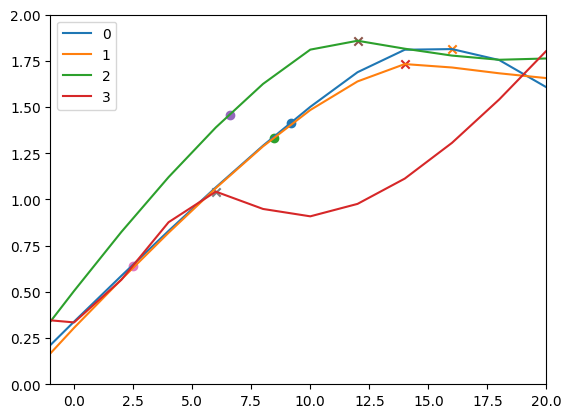

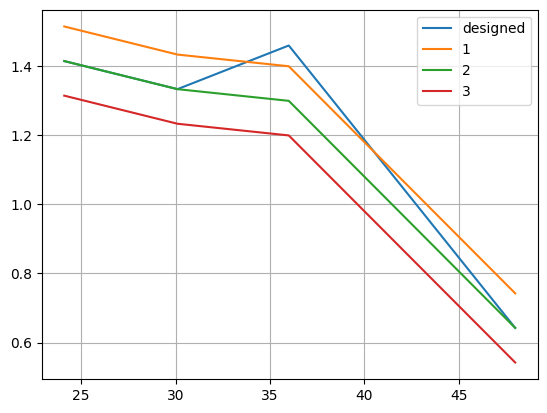

In [76]:
"""Step 6"""
"""I started working here
My goal was to use the data that we have from the 10MW pc.dat file for the cl and cd and alpha to determine for each type of blade what what the cl, cd and aoa at the maximum cl/cd
Then generate a function get_design_functions_10MW() that will take into consideration those values in order to get the cl cd and aoa designed 
and then plot everything using the previous method view in the exercice of week 3
BUT THE PLOTS ARE A BIT WEIRD please have a look"""


#Define a cl plot for the 10MW using the pc.dat
Data_cl = load_pc("DTU_10MW_RWT_pc.dat") #return a list per blade
n=len(Data_cl)-2
des_param=np.zeros((4,n))
#print(Data_cl)
arg_0=[63,63,63,58]
for k in range(n):
    plt.plot(Data_cl[k]["aoa_deg"],Data_cl[k]["cl"],label=f"{k}")
    cl_1=np.amax(Data_cl[k]["cl"][50:arg_0[k]])
    arg_1=np.where(Data_cl[k]["cl"]==cl_1)
    aoa_1=Data_cl[k]["aoa_deg"][arg_1]
    cl_des=cl_1-0.4
    aoa_des=np.interp(cl_des,Data_cl[k]["cl"][50:arg_0[k]],Data_cl[k]["aoa_deg"][50:arg_0[k]])
    cd_des=np.interp(cl_des,Data_cl[k]["cl"][50:arg_0[k]],Data_cl[k]["cd"][50:arg_0[k]])
    des_param[:,k]=[Data_cl[k]["tc"],cl_des,cd_des,aoa_des]
    print(cl_1)
    plt.scatter(aoa_des,cl_des,marker="o")
    plt.scatter(aoa_1,cl_1,marker="x")
print(des_param)
plt.xlim(-1,20)
plt.ylim(0,2)
plt.legend()
plt.show()

plt.plot(des_param[0,:],des_param[1,:], label="designed")

for i in range(1,4):
    _, _, _, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(i)
    plt.plot(tc_vals, cl_vals, label=f"{i}")

plt.legend()
plt.grid()
plt.show()

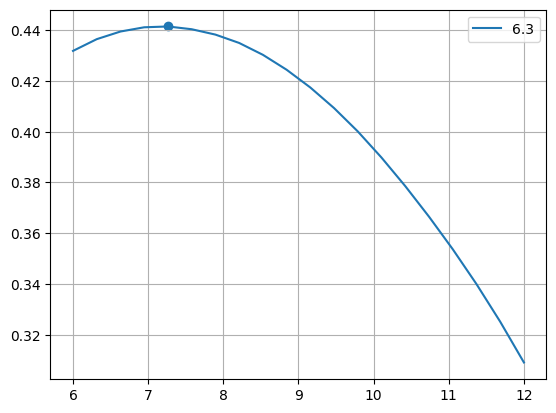

0.4414323017299089 7.2631578947368425


In [114]:
"""Step 7"""

# %% Inputs
R = R_Y  # Rotor radius [m]
r_hub = 2.8  # Hub radius [m]
r = np.linspace(r_hub, R - 0.1, 40)  # Rotor span [m]

#chord_max = np.amax(abs_t)/(np.amax(des_param[0,:])/100) # Maximum chord size [m] 
"""BE CAREFUL HOW TO CHOOSE CHORD MAX"""

chord_root = 5.38  # Chord size at the root [m]
t = t # Absolute thickness [m]
B = 3  # Number of blades [#]
# Aero dynamic polar design functions and the values (t/c vs. cl, cd, aoa)
cl_scale = 1.0  # Change this value to scale the cl-values
cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(2)


TSR=np.linspace(6,12,20)
chord_max_list = [6.3]
for chord_max in chord_max_list:
    CP_list =[]
    for tsr in TSR:
        # %% Solving for the a single design
        chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
            r, t, tsr, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B)
        CP_list.append(CP)


    plt.plot(TSR,CP_list,label=f"{chord_max}")

CP_max=np.amax(CP_list)
TSR_max=TSR[np.argmax(CP_list)]

plt.scatter(TSR_max,CP_max)
plt.legend()
plt.grid()
plt.show()

print(CP_max,TSR_max) #Obtained TSR




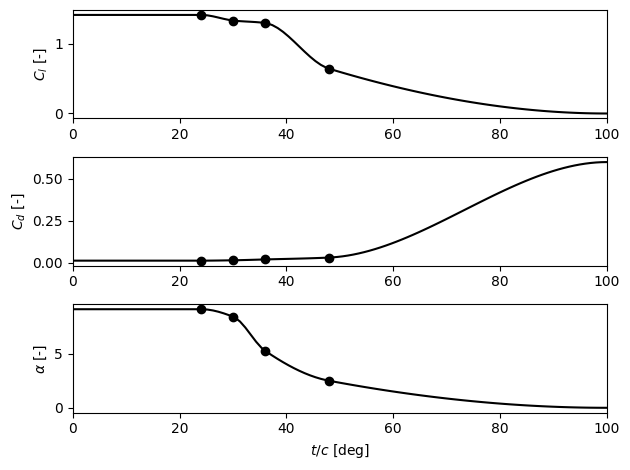

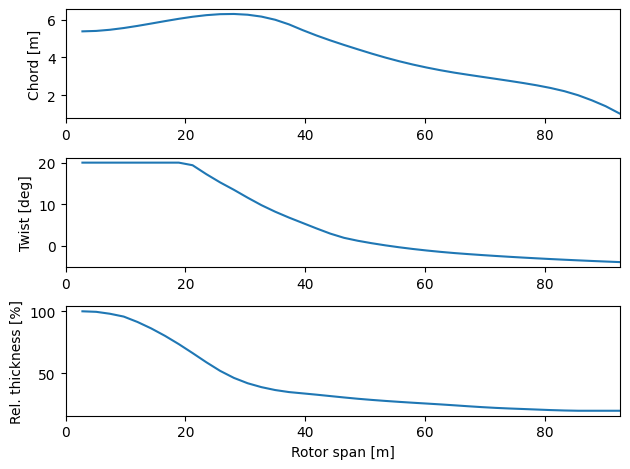

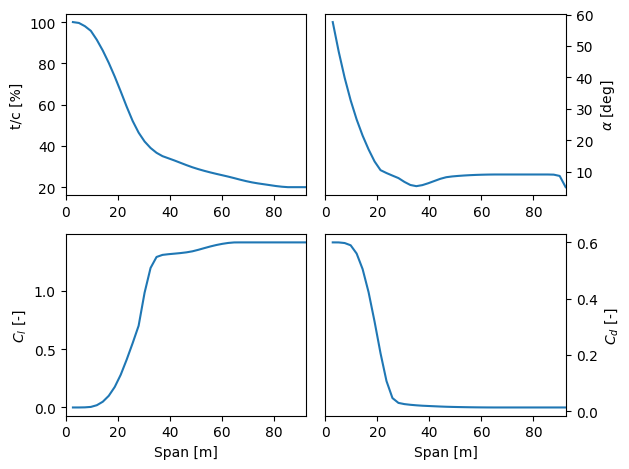

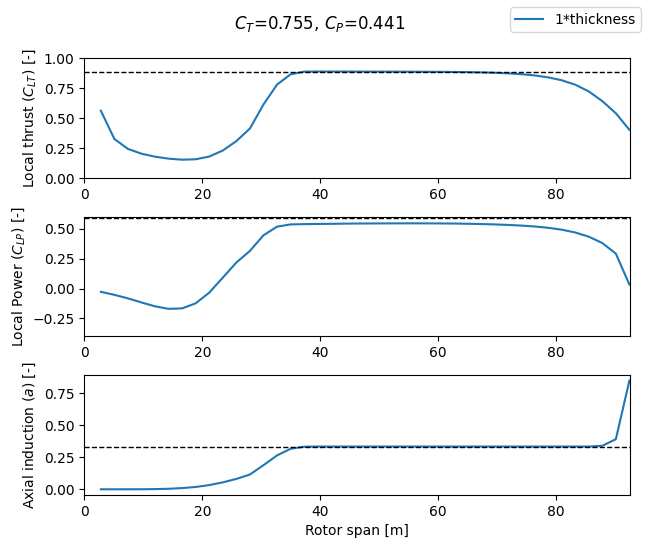

In [113]:
# %% Inputs
R = R_Y  # Rotor radius [m]
tsr = TSR_max  # Tip-Speed-Ratio [-]
r_hub = 2.8  # Hub radius [m]
r = np.linspace(r_hub, R - 0.1, 40)  # Rotor span [m]
chord_max = 6.3  # Maximum chord size [m]
chord_root = 5.38  # Chord size at the root [m]
t = t # Absolute thickness [m]
B = 3  # Number of blades [#]
# Aero dynamic polar design functions and the values (t/c vs. cl, cd, aoa)
cl_scale = 1.0  # Change this value to scale the cl-values
cl_des, cd_des, aoa_des, tc_vals, cl_vals, cd_vals, aoa_vals = get_design_functions(
    2
)

# %% Solving for the a single design
chord, tc, twist, cl, cd, aoa, a, CLT, CLP, CT, CP = single_point_design(
    r, t, tsr, R, cl_des, cd_des, aoa_des, chord_root, chord_max, B
)

tc_plot = np.linspace(0, 100, 100)
fig1, axs1 = plt.subplots(3, 1, num=1)

axs1[0].plot(tc_plot, cl_des(tc_plot), "k")
axs1[0].plot(tc_vals, cl_vals, "ok")
axs1[0].set_ylabel("$C_l$ [-]")
axs1[0].set_xlim(0, 100)

axs1[1].plot(tc_plot, cd_des(tc_plot), "k")
axs1[1].plot(tc_vals, cd_vals, "ok")
axs1[1].set_ylabel("$C_d$ [-]")
axs1[1].set_xlim(0, 100)

axs1[2].plot(tc_plot, aoa_des(tc_plot), "k")
axs1[2].plot(tc_vals, aoa_vals, "ok")
axs1[2].set_ylabel(r"$\alpha$ [-]")
axs1[2].set_xlabel(r"$t/c$ [deg]")
axs1[2].set_xlim(0, 100)

fig1.tight_layout()

# %% Plot the chord, twist and relative-thickness
fig2, axs2 = plt.subplots(3, 1, num=2, clear=True)

# Chord
axs2[0].plot(r, chord)
axs2[0].set_ylabel("Chord [m]")
axs2[0].set_xlim(0, R)

# Twist
axs2[1].plot(r, twist)
axs2[1].set_ylabel("Twist [deg]")
axs2[1].set_xlim(0, R)

# t/c
axs2[2].plot(r, tc)
axs2[2].set_ylabel("Rel. thickness [%]")
axs2[2].set_xlabel("Rotor span [m]")
axs2[2].set_xlim(0, R)

fig2.tight_layout()

# %% Plot r vs. t/c, aoa, cl, cd
fig3, axs3 = plt.subplots(2, 2, num=3, clear=True)

# t/c
axs3[0, 0].plot(r, tc)
axs3[0, 0].set_ylabel("t/c [%]")
axs3[0, 0].set_xlim(0, R)

# aoa
axs3[0, 1].plot(r, aoa)
axs3[0, 1].set_ylabel(r"$\alpha$ [deg]")
axs3[0, 1].set_xlim(0, R)
axs3[0, 1].yaxis.tick_right()
axs3[0, 1].yaxis.set_label_position("right")

# cl
axs3[1, 0].plot(r, cl)
axs3[1, 0].set_ylabel("$C_l$ [-]")
axs3[1, 0].set_xlabel("Span [m]")
axs3[1, 0].set_xlim(0, R)

# cd
axs3[1, 1].plot(r, cd)
axs3[1, 1].set_ylabel("$C_d$ [-]")
axs3[1, 1].set_xlabel("Span [m]")
axs3[1, 1].set_xlim(0, R)
axs3[1, 1].yaxis.tick_right()
axs3[1, 1].yaxis.set_label_position("right")

fig3.tight_layout()

# %% Plot r vs. CLT, CLP, a
fig4, axs4 = plt.subplots(3, 1, num=4, clear=True, figsize=(6.5, 5.5))

# Local-Thrust-Coefficient
axs4[0].plot(r, CLT, label="1*thickness")
axs4[0].axhline(y=8 / 9, ls="--", color="k", lw=1)
axs4[0].set_ylabel("Local thrust ($C_{LT}$) [-]")
axs4[0].set_ylim(0, 1.0)
axs4[0].set_xlim(0, R)


# Local-Power-Coefficient
axs4[1].plot(r, CLP)
axs4[1].axhline(y=16 / 27, ls="--", color="k", lw=1)
axs4[1].set_ylabel("Local Power ($C_{LP}$) [-]")
axs4[1].set_xlim(0, R)
axs4[1].set_ylim(-0.4, 0.6)

# Axial Induction
axs4[2].plot(r, a)
axs4[2].axhline(y=1 / 3, ls="--", color="k", lw=1)
axs4[2].set_ylabel("Axial induction ($a$) [-]")
axs4[2].set_xlabel("Rotor span [m]")
axs4[2].set_xlim(0, R)

fig4.legend()
fig4.suptitle(f"$C_T$={CT:1.3f}, $C_P$={CP:1.3f}")#, $C_T_Rel_Thi$={CT1:1.3f}, $C_P_Rel_Thi$={CP1:1.3f}")
fig4.tight_layout()

plt.show()